In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import metrics
from sklearn import tree

from features import *
from utils import *

In [2]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, str(z), ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
    fig.colorbar(cax)
    
    # Define os ticks antes de definir os rótulos
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Data Preparation

In [3]:
# classes of machine faults in the dataset
CLASS_OFF       = 0
CLASS_HEALTH    = 1
CLASS_BEARING   = 2
CLASS_FAN       = 3
CLASS_GEAR      = 4

CLASSES = [CLASS_OFF, CLASS_HEALTH, CLASS_BEARING, CLASS_FAN, CLASS_GEAR]

In [4]:
# directory containing audio files
DIR = "data"

In [5]:
# audio file per class
FILE_OFF        = "M1_OFF_S1.flac"
FILE_HEALTH     = "M1_H_S1.flac"
FILE_BEARING    = "M1_F1_S1.flac"
FILE_FAN        = "M1_F2_S1.flac"
FILE_GEAR       = "M1_F3_S1.flac"

In [6]:
# read audio files
signal_off,     sampling_frequency_off      = read_audio(f"{DIR}/{FILE_OFF}")
signal_health,  sampling_frequency_health   = read_audio(f"{DIR}/{FILE_HEALTH}")
signal_bearing, sampling_frequency_bearing  = read_audio(f"{DIR}/{FILE_BEARING}")
signal_fan,     sampling_frequency_fan      = read_audio(f"{DIR}/{FILE_FAN}")
signal_gear,    sampling_frequency_gear     = read_audio(f"{DIR}/{FILE_GEAR}")

## Signal Preprocessing

In [7]:
# stereo to mono
MIXING_METHOD = "sum" # "average", "median", "max", "min", "sum"

signal_off     = stereo_to_mono(signal_off,     method=MIXING_METHOD)
signal_health  = stereo_to_mono(signal_health,  method=MIXING_METHOD)
signal_bearing = stereo_to_mono(signal_bearing, method=MIXING_METHOD)
signal_fan     = stereo_to_mono(signal_fan,     method=MIXING_METHOD)
signal_gear    = stereo_to_mono(signal_gear,    method=MIXING_METHOD)

In [8]:
# normalize audio
NORMALIZE_DBFS = -6 # dBFS

signal_off     = normalize(signal_off,     dbfs=NORMALIZE_DBFS)
signal_health  = normalize(signal_health,  dbfs=NORMALIZE_DBFS)
signal_bearing = normalize(signal_bearing, dbfs=NORMALIZE_DBFS)
signal_fan     = normalize(signal_fan,     dbfs=NORMALIZE_DBFS)
signal_gear    = normalize(signal_gear,    dbfs=NORMALIZE_DBFS)

In [9]:
# resample audio
SAMPLING_RATE = 16000 # Hz

signal_off      = resample( signal_off,
                            input_sampling_frequency=sampling_frequency_off,
                            output_sampling_frequency=SAMPLING_RATE)
signal_health   = resample( signal_health,
                            input_sampling_frequency=sampling_frequency_health,
                            output_sampling_frequency=SAMPLING_RATE)
signal_bearing  = resample( signal_bearing,
                            input_sampling_frequency=sampling_frequency_bearing,
                            output_sampling_frequency=SAMPLING_RATE)
signal_fan      = resample( signal_fan,
                            input_sampling_frequency=sampling_frequency_fan,
                            output_sampling_frequency=SAMPLING_RATE)
signal_gear     = resample( signal_gear,
                            input_sampling_frequency=sampling_frequency_gear,
                            output_sampling_frequency=SAMPLING_RATE)

In [10]:
# remove silence
SILENCE_THRESHOLD_DBFS = -48 # dBFS

signal_off      = remove_silence(signal_off,    threshold_dbfs=SILENCE_THRESHOLD_DBFS)
signal_health   = remove_silence(signal_health, threshold_dbfs=SILENCE_THRESHOLD_DBFS)
signal_bearing  = remove_silence(signal_bearing,threshold_dbfs=SILENCE_THRESHOLD_DBFS)
signal_fan      = remove_silence(signal_fan,    threshold_dbfs=SILENCE_THRESHOLD_DBFS)
signal_gear     = remove_silence(signal_gear,   threshold_dbfs=SILENCE_THRESHOLD_DBFS)

In [11]:
# segment audio
WINDOW_DURATION     = 500 # ms
OVERLAP_DURATION    = 100 # ms

segments_off     = segment_signal(  signal_off,
                                    sampling_frequency=SAMPLING_RATE,
                                    segment_duration=WINDOW_DURATION,
                                    overlap_duration=OVERLAP_DURATION)
segments_health  = segment_signal(  signal_health,
                                    sampling_frequency=SAMPLING_RATE,
                                    segment_duration=WINDOW_DURATION,
                                    overlap_duration=OVERLAP_DURATION)
segments_bearing = segment_signal(  signal_bearing,
                                    sampling_frequency=SAMPLING_RATE,
                                    segment_duration=WINDOW_DURATION,
                                    overlap_duration=OVERLAP_DURATION)
segments_fan     = segment_signal(  signal_fan,
                                    sampling_frequency=SAMPLING_RATE,
                                    segment_duration=WINDOW_DURATION,
                                    overlap_duration=OVERLAP_DURATION)
segments_gear    = segment_signal(  signal_gear,
                                    sampling_frequency=SAMPLING_RATE,
                                    segment_duration=WINDOW_DURATION,
                                    overlap_duration=OVERLAP_DURATION)

## Machine Learning

In [12]:
# feature extraction
FEATURES_LST = ["mean",
                "median",
                "variance",
                "standard_deviation",
                "skewness",
                "kurtosis",
                "root_mean_square", 
                "zero_crossing_rate"
                ]

features_off        = get_features(segments_off,        features=FEATURES_LST)
features_health     = get_features(segments_health,     features=FEATURES_LST)
features_bearing    = get_features(segments_bearing,    features=FEATURES_LST)
features_fan        = get_features(segments_fan,        features=FEATURES_LST)
features_gear       = get_features(segments_gear,       features=FEATURES_LST)

In [13]:
# feature matrix creation
X = np.vstack(( features_off,
                features_health,
                features_bearing,
                features_fan,
                features_gear))

# labels vector creation
y = np.concatenate((np.zeros(len(features_off)),
                    np.ones(len(features_health)),
                    np.full(len(features_bearing), 2),
                    np.full(len(features_fan), 3),
                    np.full(len(features_gear), 4)))

In [14]:
# splitting the data into training and test sets
TEST_SIZE = 0.20
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [15]:
# fitting the decision tree classifier
clf = tree.DecisionTreeClassifier()
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
fdtree_cv_scores = model_selection.cross_val_score(clf, X_train, y_train, cv=skf)

# fitting the decision tree classifier
trained_model = clf.fit(X_train, y_train)
y_pred = trained_model.predict(X_test)

# tree params
print(f"Tree Max Depth: {trained_model.tree_.max_depth}")
print(f"Tree Leaves:    {trained_model.tree_.n_leaves}")
print(f"--------------")

# cross-validation results
print(f"Acc per fold: {[f'{s:.4f}' for s in fdtree_cv_scores]}")
print(f"Mean accuracy: {fdtree_cv_scores.mean():.4f}")

Tree Max Depth: 6
Tree Leaves:    8
--------------
Acc per fold: ['1.0000', '0.9903', '0.9903', '0.9903', '0.9902']
Mean accuracy: 0.9922


Classification report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        24
         1.0       1.00      1.00      1.00        31
         2.0       1.00      0.96      0.98        24
         3.0       1.00      1.00      1.00        18
         4.0       1.00      1.00      1.00        32

    accuracy                           0.99       129
   macro avg       0.99      0.99      0.99       129
weighted avg       0.99      0.99      0.99       129

--------------
Feature importances:
mean: 0.1897
median: 0.0000
variance: 0.5434
standard_deviation: 0.0000
skewness: 0.0042
kurtosis: 0.2339
root_mean_square: 0.0287
zero_crossing_rate: 0.0000
--------------


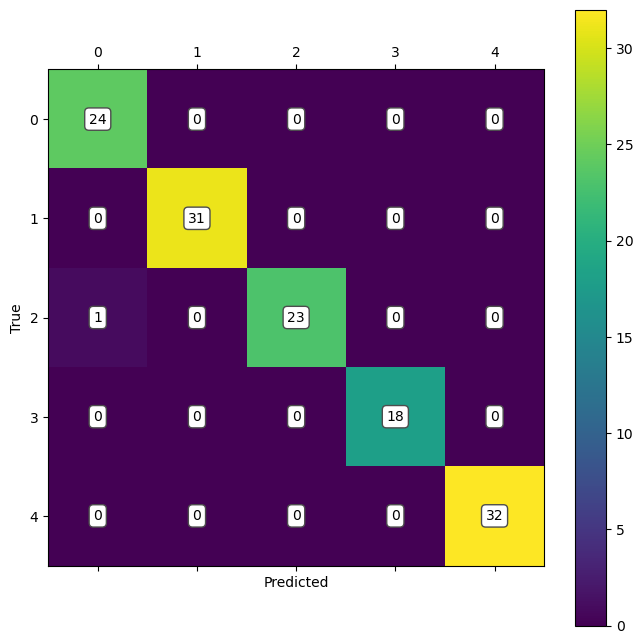

In [16]:
# printing classification report
print("Classification report:")
print(metrics.classification_report(y_true=y_test, y_pred=y_pred))
print(f"--------------")

# printing feature importances
print("Feature importances:")
for i, feature in enumerate(FEATURES_LST):
    print(f"{feature}: {clf.feature_importances_[i]:.4f}")
print(f"--------------")

# plotting confusion matrix
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, labels=list(set(CLASSES)))